In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random
from sklearn import linear_model

In [102]:
def pairs_to_rand(adj):
    #given a graph, for all pairs (i,j) return sorted list of ((i, j), number of vertices in connected comps)
    
    pairs_dict = {}
    p = adj.shape[0]
    graph = nx.from_numpy_matrix(adj)
    
    for k in range(p):
        neighs_k = graph[k]
        graph_copy = graph.copy()
        for node in neighs_k:
            graph_copy.remove_node(node)
        graph_copy.remove_node(k)
        for l in range(p):
            if l in graph_copy: #not removed
                cc_sz = len(nx.node_connected_component(graph_copy, l))
                pairs_dict[(k, l)] = cc_sz
    
    return sorted(pairs_dict.items(), key=lambda x: x[1], reverse = True)

In [296]:
def empirical_cov(p, cov, subsets, i, j, trials = 1000):
    coefs = np.zeros((trials, len(subsets)))
    for t in range(trials):
        sample = np.random.multivariate_normal(np.zeros(p), cov, size = 10000)
        S = np.cov(sample.T)
        for s, N_i in enumerate(subsets):
            coef_mat = np.linalg.inv(submatrix(S, N_i))
            target_idx = subset_idx(i, j, N_i)
            #target_idx = idx(N_i.index(i), N_i.index(j), len(N_i))
            coef = mat_to_vec(coef_mat)[target_idx]
            coefs[t, s] = coef
    #print(coefs)
    return np.cov(coefs.T)

def empirical_cov_gen_stat(stat_func, p, cov, subsets, k, l, trials = 100):
    stats = np.zeros((trials, len(subsets))) #each row is a different trial, column is different subset
    for t in range(trials):
        sample = np.random.multivariate_normal(np.zeros(p), cov, size = 10000)
        S = np.cov(sample.T)
        for s, N_i in enumerate(subsets):
            stat = stat_func(S, N_i, k, l)
            stats[t, s] = stat
    return np.cov(stats.T)

In [269]:
def partial_corr(S, subset, k, l):
    coef_mat = np.linalg.inv(submatrix(S, subset))
    target_idx = subset_idx(k, l, subset)
    coef = mat_to_vec(coef_mat)[target_idx]
    return coef

In [277]:
def partial_corr_trans(S, subset, k, l):
    r = partial_corr(S, subset, k, l)
    return float(r)/(1.-r**2)

In [303]:
def fisher_z_trans(S, subset, k, l):
    r = partial_corr(S, subset, k, l)
    return 0.5 * np.log(float(1+r)/(1.-r))

In [304]:
def partial_corr_sq(S, subset, k, l):
    r = partial_corr(S, subset, k, l)
    return np.sign(r) * r**2

In [200]:
def assemble_I_mat(subsets, E, k, l):
    #E is the covariance
    rows = []
    p = E.shape[0]
    for N_i in subsets: 
        E_i_inv = np.linalg.inv(submatrix(E, N_i))
        D_i = construct_D(p, N_i)
        I_i = isserling(E_i_inv)
        target_idx = subset_idx(k,l, N_i)
        row = I_i.dot(D_i)[target_idx]
        rows.append(row)
    return np.array(rows)

Took 1 tries


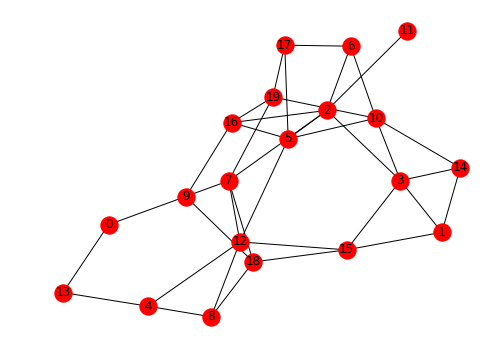

In [308]:
p = 20
adj = generate_connected_mat(p)
#adj to covariance matrix
cov = adj_to_cov(adj)
assert_PSD(cov)
#print(cov)
#assert_symm(cov)
G = isserlis(cov)
pair_dict = pairs_to_rand(adj)
for (k, l), _ in pair_dict[:2]:
    subsets = assemble_subsets(adj, k, l, 4)
    par_corr_cov = empirical_cov_gen_stat(partial_corr, p, cov, subsets, k, l, trials = 1000)
    par_corr_trans_cov = empirical_cov_gen_stat(partial_corr_trans, p, cov, subsets, k, l, trials = 1000)
    fztrans = empirical_cov_gen_stat(fisher_z_trans, p, cov, subsets, k, l, trials = 1000)
    sq = empirical_cov_gen_stat(partial_corr_sq, p, cov, subsets, k, l, trials = 1000)
    break
    '''res = assemble_I_mat(subsets, cov, k, l)
    uma_I = res.dot(G).dot(res.T)
    print("uma I PSD")
    assert_PSD(uma_I)
    s_I = sleppian(uma_I)
    print("sleppian I PSD")
    assert_PSD(s_I)
    
    print(np.diag(uma_I))
    print(k, l, '\n', subsets)
    print("Rank of og: {}, sleppian: {}".format(np.linalg.matrix_rank(uma_I), np.linalg.matrix_rank(s_I)))
    print("og eigvals", sorted(np.linalg.eigvals(uma_I)))
    print("sleppian eigvals", sorted(np.linalg.eigvals(s_I)))'''

In [310]:
for cov in [par_corr_cov, par_corr_trans_cov, fztrans, sq]:
    print(sorted(np.linalg.eigvals(cov)))
    print(sorted(np.linalg.eigvals(sleppian(cov))))

[1.811026964218246e-07, 5.077708257167695e-07, 2.033104458398413e-06, 0.000709058540513799]
[-1.2193318501300797e-06, -3.2410434937645664e-07, 2.0006023439853412e-06, 0.000711323352349857]
[1.958213609493636e-07, 4.982310925967866e-07, 2.1671193024212154e-06, 0.0006580247470905297]
[-1.5634005228237935e-06, -8.49593365803258e-07, 2.5090314755469393e-06, 0.0006607898812595774]
[1.8373387817451076e-07, 5.296236372460924e-07, 2.2859168496712842e-06, 0.000694577180756921]
[-5.471630421768992e-07, 2.2363297809271999e-07, 2.0275341728891956e-06, 0.0006958724510132078]
[1.2333218267132178e-10, 3.3116393572451077e-10, 1.249846103273583e-09, 3.0417883982088487e-07]
[-9.063827146563064e-11, 3.2998754937231577e-10, 9.092516117301456e-10, 3.0473458115291756e-07]


In [187]:
#This is old form of calculating the covariance matrix (before it was expressed as an inner product)
'''def numerical_calcs(subsets, S, E, p):
    matrices = []
    variances = []

    for N_i in subsets: 
        #S_i = submatrix(S, N_i)
        #E_i = submatrix(E, N_i)
        E_i_inv = np.linalg.inv(submatrix(E, N_i))
        print(N_i)
        print(list(zip(N_i, E_i_inv[N_i.index(j)])))
        D_i = construct_D(p, N_i)
        I_i = isserling(E_i_inv)
        E_var_i = I_i.dot(D_i).dot(G).dot(D_i.T).dot(I_i.T)
        matrices.append((E_i_inv, I_i, D_i))

        target_idx = subset_idx(i, j, N_i)
        variances.append(E_var_i[target_idx, target_idx])

    sz = len(subsets)
    pred_cov = np.zeros((sz, sz))

    for x in range(len(subsets)):
        for y in range(len(subsets)):
            if x == y:
                pred_cov[x][y] = variances[x]
            else: #calculate the cov
                E_i_inv, I_i, D_i = matrices[x]
                E_j_inv, I_j, D_j = matrices[y]
                cov_xy = I_i.dot(D_i).dot(G).dot(D_j.T).dot(I_j.T)
                N_i = subsets[x]
                N_j = subsets[y]

                target_idx_x = subset_idx(i, j, N_i)
                target_idx_y = subset_idx(i, j, N_j)
                pred_cov[x][y] = cov_xy[target_idx_x, target_idx_y]

    print("Numerically calculated covariance")
    print(pred_cov)

    print("Numerical covariance eigenvalues")
    print(np.linalg.eigvals(pred_cov))

    print("Numerically calculated correlation")
    pred_corr = cov_to_corr(pred_cov)
    print(pred_corr)

    print("Rank of covariance matrix: {}".format(np.linalg.matrix_rank(pred_cov)))'''